In [1]:
import glob
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
import natsort

In [2]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [3]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2

In [4]:
#existing
V_path= 'D:/sensors journal/TT_V/train/existing/txt'
V_files = glob.glob(os.path.join(V_path, "*.txt"))
V_files = natsort.natsorted(V_files)
print(V_files)
V_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in V_files)

['D:/sensors journal/TT_V/train/existing/txt\\1.txt', 'D:/sensors journal/TT_V/train/existing/txt\\2.txt', 'D:/sensors journal/TT_V/train/existing/txt\\3.txt', 'D:/sensors journal/TT_V/train/existing/txt\\4.txt', 'D:/sensors journal/TT_V/train/existing/txt\\5.txt', 'D:/sensors journal/TT_V/train/existing/txt\\6.txt', 'D:/sensors journal/TT_V/train/existing/txt\\7.txt', 'D:/sensors journal/TT_V/train/existing/txt\\8.txt', 'D:/sensors journal/TT_V/train/existing/txt\\9.txt', 'D:/sensors journal/TT_V/train/existing/txt\\10.txt', 'D:/sensors journal/TT_V/train/existing/txt\\11.txt', 'D:/sensors journal/TT_V/train/existing/txt\\12.txt', 'D:/sensors journal/TT_V/train/existing/txt\\13.txt', 'D:/sensors journal/TT_V/train/existing/txt\\14.txt', 'D:/sensors journal/TT_V/train/existing/txt\\15.txt', 'D:/sensors journal/TT_V/train/existing/txt\\16.txt', 'D:/sensors journal/TT_V/train/existing/txt\\17.txt', 'D:/sensors journal/TT_V/train/existing/txt\\18.txt', 'D:/sensors journal/TT_V/train/exist

In [5]:
#test 데이터
test_V_path= 'D:/sensors journal/TT_V/test/existing/txt'
test_V_files = glob.glob(os.path.join(test_V_path, "*.txt"))
test_V_files = natsort.natsorted(test_V_files)
print(test_V_files)
test_V_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in test_V_files)

['D:/sensors journal/TT_V/test/existing/txt\\1.txt', 'D:/sensors journal/TT_V/test/existing/txt\\2.txt', 'D:/sensors journal/TT_V/test/existing/txt\\3.txt', 'D:/sensors journal/TT_V/test/existing/txt\\4.txt', 'D:/sensors journal/TT_V/test/existing/txt\\5.txt', 'D:/sensors journal/TT_V/test/existing/txt\\6.txt', 'D:/sensors journal/TT_V/test/existing/txt\\7.txt', 'D:/sensors journal/TT_V/test/existing/txt\\8.txt', 'D:/sensors journal/TT_V/test/existing/txt\\9.txt', 'D:/sensors journal/TT_V/test/existing/txt\\10.txt', 'D:/sensors journal/TT_V/test/existing/txt\\11.txt', 'D:/sensors journal/TT_V/test/existing/txt\\12.txt', 'D:/sensors journal/TT_V/test/existing/txt\\13.txt', 'D:/sensors journal/TT_V/test/existing/txt\\14.txt', 'D:/sensors journal/TT_V/test/existing/txt\\15.txt', 'D:/sensors journal/TT_V/test/existing/txt\\16.txt', 'D:/sensors journal/TT_V/test/existing/txt\\17.txt', 'D:/sensors journal/TT_V/test/existing/txt\\18.txt', 'D:/sensors journal/TT_V/test/existing/txt\\19.txt', '

In [6]:
#class별 비율 확인 - feature 추가된 파일
V_file_list = list(V_each_file)
print(V_file_list)
input_num=12
ratio = 2
sampling_ratio_V = []

for i in V_file_list:
    class0 = len(i[i[input_num]==0]) 
    class1 = len(i[i[input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    sampling_ratio_V.append(ratio*class1/class0)

[        0    1   2       3    4       5    6    7       8       9       10  \
0     0.50  1.0   1  0.6667  1.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
1     0.50  1.0   1  0.8000  0.5  1.0000  1.0  1.0  0.3333  0.1667  0.3175   
2     0.50  1.0   0  0.5000  1.0  0.0758  0.0  1.0  0.3333  0.0000  0.3175   
3     0.50  0.5   1  0.2000  1.0  0.0606  0.5  1.0  0.3333  0.0000  0.3175   
4     0.75  1.0   0  0.3333  0.5  0.2424  0.5  1.0  0.3333  0.0000  0.3175   
...    ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
5244  0.50  0.0   0  0.5000  0.0  0.7727  0.5  1.0  1.0000  0.0000  0.6349   
5245  0.50  0.0   0  0.5000  0.0  0.7576  0.5  1.0  1.0000  0.0000  0.6349   
5246  0.50  0.0   1  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5247  0.50  0.0   1  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5248  0.50  0.0   1  0.5000  0.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   

      11  12  
0      1   0  
1      1   1  
2      1   0  
3 

class0:  3636
class1:  952
class0/class1:  3.82
sampling ratio:  0.52 

class0:  10687
class1:  1144
class0/class1:  9.34
sampling ratio:  0.21 

class0:  2454
class1:  118
class0/class1:  20.80
sampling ratio:  0.10 

class0:  4582
class1:  712
class0/class1:  6.44
sampling ratio:  0.31 

class0:  5653
class1:  268
class0/class1:  21.09
sampling ratio:  0.09 

class0:  10887
class1:  1308
class0/class1:  8.32
sampling ratio:  0.24 

class0:  56730
class1:  10344
class0/class1:  5.48
sampling ratio:  0.36 

class0:  39232
class1:  3615
class0/class1:  10.85
sampling ratio:  0.18 

class0:  38039
class1:  3106
class0/class1:  12.25
sampling ratio:  0.16 

class0:  52387
class1:  6222
class0/class1:  8.42
sampling ratio:  0.24 

class0:  435
class1:  25
class0/class1:  17.40
sampling ratio:  0.11 

class0:  1090
class1:  86
class0/class1:  12.67
sampling ratio:  0.16 

class0:  6686
class1:  1375
class0/class1:  4.86
sampling ratio:  0.41 

class0:  30434
class1:  3022
class0/class1:  10

class0:  9351
class1:  1502
class0/class1:  6.23
sampling ratio:  0.32 

class0:  17950
class1:  2772
class0/class1:  6.48
sampling ratio:  0.31 

class0:  2669
class1:  89
class0/class1:  29.99
sampling ratio:  0.07 

class0:  3810
class1:  436
class0/class1:  8.74
sampling ratio:  0.23 

class0:  35870
class1:  2902
class0/class1:  12.36
sampling ratio:  0.16 

class0:  29675
class1:  1033
class0/class1:  28.73
sampling ratio:  0.07 

class0:  2657
class1:  377
class0/class1:  7.05
sampling ratio:  0.28 

class0:  412
class1:  30
class0/class1:  13.73
sampling ratio:  0.15 

class0:  3223
class1:  183
class0/class1:  17.61
sampling ratio:  0.11 

class0:  3358
class1:  432
class0/class1:  7.77
sampling ratio:  0.26 

class0:  39183
class1:  9486
class0/class1:  4.13
sampling ratio:  0.48 

class0:  3690
class1:  116
class0/class1:  31.81
sampling ratio:  0.06 

class0:  27260
class1:  6054
class0/class1:  4.50
sampling ratio:  0.44 

class0:  33229
class1:  6043
class0/class1:  5.50


sampling ratio:  0.15 

class0:  4646
class1:  21
class0/class1:  221.24
sampling ratio:  0.01 

class0:  20059
class1:  3757
class0/class1:  5.34
sampling ratio:  0.37 

class0:  2817
class1:  356
class0/class1:  7.91
sampling ratio:  0.25 

class0:  47884
class1:  8463
class0/class1:  5.66
sampling ratio:  0.35 

class0:  14093
class1:  784
class0/class1:  17.98
sampling ratio:  0.11 

class0:  38476
class1:  2871
class0/class1:  13.40
sampling ratio:  0.15 

class0:  15188
class1:  1229
class0/class1:  12.36
sampling ratio:  0.16 

class0:  28560
class1:  3313
class0/class1:  8.62
sampling ratio:  0.23 

class0:  26110
class1:  2571
class0/class1:  10.16
sampling ratio:  0.20 

class0:  15470
class1:  1726
class0/class1:  8.96
sampling ratio:  0.22 

class0:  3786
class1:  413
class0/class1:  9.17
sampling ratio:  0.22 

class0:  3597
class1:  278
class0/class1:  12.94
sampling ratio:  0.15 

class0:  2939
class1:  585
class0/class1:  5.02
sampling ratio:  0.40 

class0:  11871
clas

In [7]:
#class별 비율 확인 - feature 추가된 파일
test_V_file_list = list(test_V_each_file)
print(test_V_file_list)
test_sampling_ratio_V = []

for i in test_V_file_list:
    class0 = len(i[i[input_num]==0]) 
    class1 = len(i[i[input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("new_sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    test_sampling_ratio_V.append(ratio*class1/class0)

[          0    1   2       3    4       5    6    7       8       9       10  \
0       0.50  1.0   1  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
1       0.50  1.0   0  0.2000  1.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
2       0.50  0.0   1  0.5000  1.0  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
3       0.75  0.0   1  0.3333  0.5  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
4       0.50  0.0   1  0.5000  1.0  1.0000  1.0  1.0  0.3333  0.1667  0.3175   
...      ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
109560  0.50  0.5   0  0.3333  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
109561  0.50  0.0   0  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.6349   
109562  0.50  0.0   1  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
109563  0.50  0.0   1  0.6667  0.5  0.5606  1.0  1.0  0.3333  0.0000  0.6349   
109564  0.50  0.0   0  0.5000  0.0  0.5455  1.0  1.0  0.3333  0.0000  0.6349   

        11  12  
0        1   1  
1   

In [8]:
#subsampling
df = pd.DataFrame()
for data, smp_ratio in  zip(V_file_list, sampling_ratio_V):
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    df = pd.concat([df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(df), '\n')

0:  4421
1:  828
concat:  5249 

0:  10141
1:  1581
concat:  16971 

0:  5050
1:  854
concat:  22875 

0:  2979
1:  550
concat:  26404 

0:  15062
1:  2516
concat:  43982 

0:  1376
1:  230
concat:  45588 

0:  3623
1:  472
concat:  49683 

0:  2139
1:  428
concat:  52250 

0:  1485
1:  185
concat:  53920 

0:  3849
1:  345
concat:  58114 

0:  5524
1:  883
concat:  64521 

0:  15448
1:  2298
concat:  82267 

0:  6702
1:  824
concat:  89793 

0:  3478
1:  547
concat:  93818 

0:  24406
1:  4972
concat:  123196 

0:  2702
1:  176
concat:  126074 

0:  5199
1:  643
concat:  131916 

0:  1886
1:  374
concat:  134176 

0:  2503
1:  131
concat:  136810 

0:  4219
1:  223
concat:  141252 

0:  5427
1:  869
concat:  147548 

0:  15512
1:  2426
concat:  165486 

0:  7752
1:  993
concat:  174231 

0:  3460
1:  543
concat:  178234 

0:  25700
1:  5599
concat:  209533 

0:  1658
1:  111
concat:  211302 

0:  6438
1:  908
concat:  218648 

0:  3329
1:  607
concat:  222584 

0:  2994
1:  181
concat

concat:  3607865 

0:  6773
1:  240
concat:  3614878 

0:  7271
1:  267
concat:  3622416 

0:  10633
1:  1195
concat:  3634244 

0:  5958
1:  231
concat:  3640433 

0:  17593
1:  1465
concat:  3659491 

0:  10825
1:  1225
concat:  3671541 

0:  31529
1:  4602
concat:  3707672 

0:  7718
1:  636
concat:  3716026 

0:  4338
1:  23
concat:  3720387 

0:  20165
1:  3878
concat:  3744430 

0:  2864
1:  302
concat:  3747596 

0:  47750
1:  8509
concat:  3803855 

0:  19370
1:  1732
concat:  3824957 

0:  39989
1:  2663
concat:  3867609 

0:  17886
1:  1478
concat:  3886973 

0:  28230
1:  3292
concat:  3918495 

0:  25643
1:  2553
concat:  3946691 

0:  15373
1:  1750
concat:  3963814 

0:  4054
1:  463
concat:  3968331 

0:  3268
1:  299
concat:  3971898 

0:  3545
1:  715
concat:  3976158 

0:  8411
1:  696
concat:  3985265 

0:  3846
1:  262
concat:  3989373 

0:  5073
1:  728
concat:  3995174 

0:  5655
1:  248
concat:  4001077 

0:  11635
1:  1453
concat:  4014165 

0:  51976
1:  9210
c

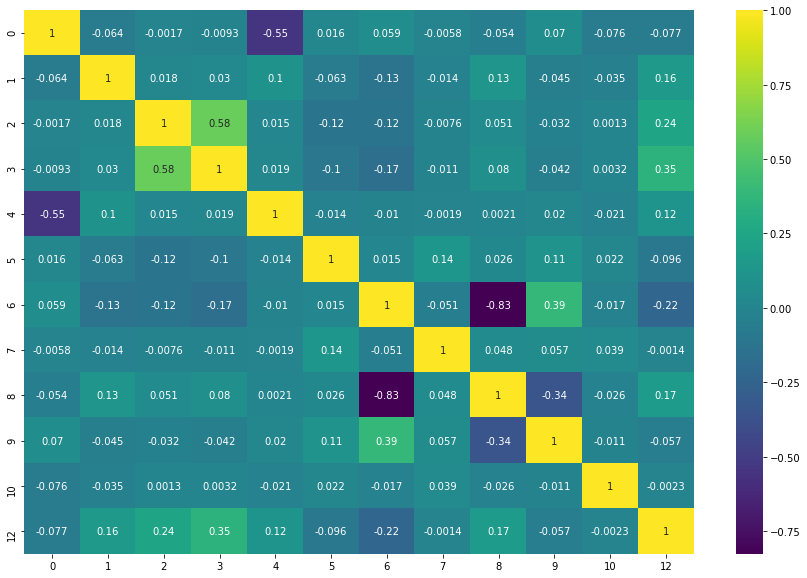

In [9]:
import seaborn as sns
df = df.drop([df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [10]:
df = df.to_numpy() 

In [11]:
# new
inp_num = 11
x = df[:, 0:inp_num]
y = df[:, inp_num]
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

In [12]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch)
    model.save('Original_Existing_model_mlp_2000.h5')
    print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/2000
53516/53516 [==============================] - 30s 567us/step - loss: 0.0970 - acc: 0.8827 - val_loss: 0.0892 - val_acc: 0.8830
Epoch 2/2000
53516/53516 [==============================] - 30s 559us/step - loss: 0.0872 - acc: 0.8830 - val_loss: 0.0859 - val_acc: 0.8833
Epoch 3/2000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0854 - acc: 0.8830 - val_loss: 0.0848 - val_acc: 0.8832
Epoch 4/2000
53516/53516 [==============================] - 33s 613us/step - loss: 0.0846 - acc: 0.8828 - val_loss: 0.0842 - val_acc: 0.8832
Epoch 5/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0841 - acc: 0.8830 - val_loss: 0.0838 - val_acc: 0.8833
Epoch 6/2000
53516/53516 [==============================] - 30s 556us/step - loss: 0.0838 - acc: 0.8831 - val_loss: 0.0835 - val_acc: 0.8835
Epoch 7/2000
53516/53516 [==============================] - 28s 518us/step - loss: 0.0836 - acc: 0.8832 - val_loss: 0.0834 - val_acc: 0.8835
Epoch 8/2000


Epoch 59/2000
53516/53516 [==============================] - 26s 485us/step - loss: 0.0826 - acc: 0.8858 - val_loss: 0.0825 - val_acc: 0.8862
Epoch 60/2000
53516/53516 [==============================] - 26s 484us/step - loss: 0.0826 - acc: 0.8858 - val_loss: 0.0825 - val_acc: 0.8861
Epoch 61/2000
53516/53516 [==============================] - 26s 482us/step - loss: 0.0825 - acc: 0.8858 - val_loss: 0.0824 - val_acc: 0.8861
Epoch 62/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0825 - acc: 0.8858 - val_loss: 0.0824 - val_acc: 0.8861
Epoch 63/2000
53516/53516 [==============================] - 26s 484us/step - loss: 0.0825 - acc: 0.8858 - val_loss: 0.0824 - val_acc: 0.8861
Epoch 64/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0825 - acc: 0.8858 - val_loss: 0.0824 - val_acc: 0.8861
Epoch 65/2000
53516/53516 [==============================] - 26s 478us/step - loss: 0.0825 - acc: 0.8858 - val_loss: 0.0824 - val_acc: 0.8861
Epoch 

53516/53516 [==============================] - 26s 485us/step - loss: 0.0821 - acc: 0.8861 - val_loss: 0.0820 - val_acc: 0.8864
Epoch 117/2000
53516/53516 [==============================] - 26s 487us/step - loss: 0.0821 - acc: 0.8861 - val_loss: 0.0820 - val_acc: 0.8864
Epoch 118/2000
53516/53516 [==============================] - 26s 488us/step - loss: 0.0821 - acc: 0.8861 - val_loss: 0.0820 - val_acc: 0.8865
Epoch 119/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0821 - acc: 0.8861 - val_loss: 0.0820 - val_acc: 0.8865
Epoch 120/2000
53516/53516 [==============================] - 26s 485us/step - loss: 0.0821 - acc: 0.8861 - val_loss: 0.0820 - val_acc: 0.8865
Epoch 121/2000
53516/53516 [==============================] - 26s 487us/step - loss: 0.0821 - acc: 0.8862 - val_loss: 0.0820 - val_acc: 0.8864
Epoch 122/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0821 - acc: 0.8861 - val_loss: 0.0820 - val_acc: 0.8865
Epoch 123/2000

53516/53516 [==============================] - 26s 485us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0818 - val_acc: 0.8867
Epoch 174/2000
53516/53516 [==============================] - 26s 482us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0819 - val_acc: 0.8866
Epoch 175/2000
53516/53516 [==============================] - 26s 485us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0818 - val_acc: 0.8866
Epoch 176/2000
53516/53516 [==============================] - 26s 494us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0818 - val_acc: 0.8867
Epoch 177/2000
53516/53516 [==============================] - 26s 487us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0818 - val_acc: 0.8867
Epoch 178/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0818 - val_acc: 0.8867
Epoch 179/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0819 - acc: 0.8864 - val_loss: 0.0818 - val_acc: 0.8867
Epoch 180/2000

53516/53516 [==============================] - 26s 486us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0817 - val_acc: 0.8869
Epoch 231/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0817 - val_acc: 0.8869
Epoch 232/2000
53516/53516 [==============================] - 26s 487us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0817 - val_acc: 0.8869
Epoch 233/2000
53516/53516 [==============================] - 26s 484us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0817 - val_acc: 0.8869
Epoch 234/2000
53516/53516 [==============================] - 26s 486us/step - loss: 0.0818 - acc: 0.8867 - val_loss: 0.0817 - val_acc: 0.8870
Epoch 235/2000
53516/53516 [==============================] - 26s 484us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0817 - val_acc: 0.8869
Epoch 236/2000
53516/53516 [==============================] - 26s 484us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0817 - val_acc: 0.8870
Epoch 237/2000

53516/53516 [==============================] - 24s 454us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 288/2000
53516/53516 [==============================] - 24s 453us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 289/2000
53516/53516 [==============================] - 24s 455us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 290/2000
53516/53516 [==============================] - 24s 454us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 291/2000
53516/53516 [==============================] - 25s 462us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 292/2000
53516/53516 [==============================] - 25s 466us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 293/2000
53516/53516 [==============================] - 24s 451us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 294/2000

53516/53516 [==============================] - 24s 453us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 345/2000
53516/53516 [==============================] - 24s 453us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 346/2000
53516/53516 [==============================] - 24s 451us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 347/2000
53516/53516 [==============================] - 24s 449us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 348/2000
53516/53516 [==============================] - 24s 453us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 349/2000
53516/53516 [==============================] - 24s 453us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 350/2000
53516/53516 [==============================] - 24s 452us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 351/2000

53516/53516 [==============================] - 34s 633us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 402/2000
53516/53516 [==============================] - 34s 642us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 403/2000
53516/53516 [==============================] - 34s 637us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8873
Epoch 404/2000
53516/53516 [==============================] - 34s 637us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 405/2000
53516/53516 [==============================] - 34s 644us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 406/2000
53516/53516 [==============================] - 34s 639us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 407/2000
53516/53516 [==============================] - 34s 642us/step - loss: 0.0817 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 408/2000

53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 459/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 460/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 461/2000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 462/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 463/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 464/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 465/2000

53516/53516 [==============================] - 32s 603us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 516/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 517/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 518/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 519/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 520/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 521/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 522/2000

53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 573/2000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 574/2000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 575/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 576/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 577/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 578/2000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 579/2000

53516/53516 [==============================] - 32s 598us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 630/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 631/2000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 632/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 633/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 634/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 635/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 636/2000

53516/53516 [==============================] - 31s 588us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 687/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 688/2000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 689/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 690/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 691/2000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 692/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 693/2000

53516/53516 [==============================] - 32s 596us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 744/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 745/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 746/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 747/2000
53516/53516 [==============================] - 31s 585us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 748/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 749/2000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 750/2000

53516/53516 [==============================] - 32s 592us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 801/2000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 802/2000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 803/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 804/2000
53516/53516 [==============================] - 31s 586us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 805/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 806/2000
53516/53516 [==============================] - 33s 613us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 807/2000

53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 858/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 859/2000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 860/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 861/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 862/2000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 863/2000
53516/53516 [==============================] - 34s 638us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 864/2000

53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 915/2000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 916/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 917/2000
53516/53516 [==============================] - 31s 585us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 918/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 919/2000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 920/2000
53516/53516 [==============================] - 31s 583us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 921/2000

53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 972/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 973/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 974/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 975/2000
53516/53516 [==============================] - 35s 647us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 976/2000
53516/53516 [==============================] - 33s 613us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 977/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 978/2000

53516/53516 [==============================] - 31s 584us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 1029/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1030/2000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1031/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1032/2000
53516/53516 [==============================] - 32s 607us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1033/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 1034/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 10

53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1086/2000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1087/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1088/2000
53516/53516 [==============================] - 34s 629us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1089/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1090/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 1091/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 10

53516/53516 [==============================] - 32s 589us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1143/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 1144/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 1145/2000
53516/53516 [==============================] - 33s 616us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1146/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1147/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1148/2000
53516/53516 [==============================] - 31s 586us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 11

53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1200/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1201/2000
53516/53516 [==============================] - 35s 659us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1202/2000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1203/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1204/2000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1205/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 12

53516/53516 [==============================] - 32s 591us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1257/2000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1258/2000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1259/2000
53516/53516 [==============================] - 31s 589us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1260/2000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1261/2000
53516/53516 [==============================] - 31s 587us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1262/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 12

53516/53516 [==============================] - 33s 608us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1314/2000
53516/53516 [==============================] - 34s 628us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1315/2000
53516/53516 [==============================] - 31s 586us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1316/2000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1317/2000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1318/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1319/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 13

53516/53516 [==============================] - 33s 610us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1371/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1372/2000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1373/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1374/2000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1375/2000
53516/53516 [==============================] - 31s 589us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1376/2000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 13

53516/53516 [==============================] - 34s 641us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1428/2000
53516/53516 [==============================] - 33s 617us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1429/2000
53516/53516 [==============================] - 34s 630us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1430/2000
53516/53516 [==============================] - 33s 617us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1431/2000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1432/2000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1433/2000
53516/53516 [==============================] - 33s 625us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 14

53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1485/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1486/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1487/2000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1488/2000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1489/2000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1490/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 14

53516/53516 [==============================] - 33s 618us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1542/2000
53516/53516 [==============================] - 33s 611us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1543/2000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1544/2000
53516/53516 [==============================] - 33s 614us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1545/2000
53516/53516 [==============================] - 33s 618us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1546/2000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1547/2000
53516/53516 [==============================] - 33s 621us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 15

53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1599/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1600/2000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1601/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1602/2000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1603/2000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1604/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 16

53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1656/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1657/2000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1658/2000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1659/2000
53516/53516 [==============================] - 33s 611us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1660/2000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1661/2000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 16

53516/53516 [==============================] - 33s 614us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1713/2000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1714/2000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1715/2000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1716/2000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1717/2000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1718/2000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 17

53516/53516 [==============================] - 32s 596us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1770/2000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1771/2000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1772/2000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1773/2000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1774/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1775/2000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 17

53516/53516 [==============================] - 32s 598us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1827/2000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1828/2000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1829/2000
53516/53516 [==============================] - 35s 651us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1830/2000
53516/53516 [==============================] - 33s 623us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1831/2000
53516/53516 [==============================] - 39s 732us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1832/2000
53516/53516 [==============================] - 38s 701us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 18

53516/53516 [==============================] - 33s 617us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1884/2000
53516/53516 [==============================] - 33s 622us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1885/2000
53516/53516 [==============================] - 33s 611us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1886/2000
53516/53516 [==============================] - 36s 675us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1887/2000
53516/53516 [==============================] - 34s 641us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1888/2000
53516/53516 [==============================] - 34s 635us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1889/2000
53516/53516 [==============================] - 34s 634us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 18

53516/53516 [==============================] - 34s 634us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1941/2000
53516/53516 [==============================] - 34s 638us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1942/2000
53516/53516 [==============================] - 34s 637us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1943/2000
53516/53516 [==============================] - 34s 634us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1944/2000
53516/53516 [==============================] - 34s 628us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1945/2000
53516/53516 [==============================] - 34s 634us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1946/2000
53516/53516 [==============================] - 34s 631us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 19

53516/53516 [==============================] - 33s 615us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1998/2000
53516/53516 [==============================] - 33s 614us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1999/2000
53516/53516 [==============================] - 33s 614us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 2000/2000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
time : 62226.778633356094


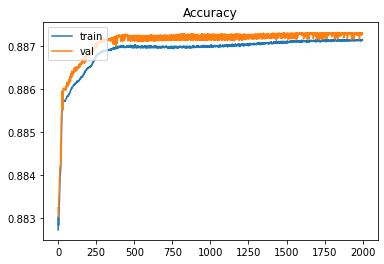

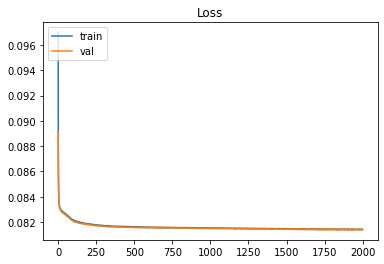

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
#모델 평가
model = load_model('Original_Existing_model_mlp_2000.h5')
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y_test, y_pred, target_names=target_names))

#위의 코드의 옛날버전
model_predictions = model.predict_classes(x_test, batch_size=200, verbose=0)
print(confusion_matrix(y_test, model_predictions))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y_test,model_predictions, target_names=target_names))
del model

In [14]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 3000

start = time.time()  # 시작 시간 저장
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch)
    model.save('Original_Existing_model_mlp_3000.h5')
    print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/3000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0960 - acc: 0.8830 - val_loss: 0.0895 - val_acc: 0.8831
Epoch 2/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0876 - acc: 0.8831 - val_loss: 0.0863 - val_acc: 0.8835
Epoch 3/3000
53516/53516 [==============================] - 33s 610us/step - loss: 0.0858 - acc: 0.8832 - val_loss: 0.0851 - val_acc: 0.8835
Epoch 4/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0849 - acc: 0.8832 - val_loss: 0.0844 - val_acc: 0.8834
Epoch 5/3000
53516/53516 [==============================] - 33s 611us/step - loss: 0.0842 - acc: 0.8833 - val_loss: 0.0839 - val_acc: 0.8835
Epoch 6/3000
53516/53516 [==============================] - 33s 610us/step - loss: 0.0839 - acc: 0.8833 - val_loss: 0.0836 - val_acc: 0.8836
Epoch 7/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0836 - acc: 0.8834 - val_loss: 0.0834 - val_acc: 0.8836
Epoch 8/3000


53516/53516 [==============================] - 32s 602us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8860
Epoch 59/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8861
Epoch 60/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8860
Epoch 61/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8860
Epoch 62/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8860
Epoch 63/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8860
Epoch 64/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0827 - acc: 0.8857 - val_loss: 0.0826 - val_acc: 0.8860
Epoch 65/3000
53516/

53516/53516 [==============================] - 33s 608us/step - loss: 0.0824 - acc: 0.8857 - val_loss: 0.0823 - val_acc: 0.8861
Epoch 116/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0823 - acc: 0.8857 - val_loss: 0.0822 - val_acc: 0.8860
Epoch 117/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0823 - acc: 0.8857 - val_loss: 0.0822 - val_acc: 0.8860
Epoch 118/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0823 - acc: 0.8857 - val_loss: 0.0822 - val_acc: 0.8861
Epoch 119/3000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0823 - acc: 0.8857 - val_loss: 0.0822 - val_acc: 0.8861
Epoch 120/3000
53516/53516 [==============================] - 33s 617us/step - loss: 0.0823 - acc: 0.8857 - val_loss: 0.0822 - val_acc: 0.8860
Epoch 121/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0823 - acc: 0.8857 - val_loss: 0.0822 - val_acc: 0.8860
Epoch 122/3000

53516/53516 [==============================] - 32s 590us/step - loss: 0.0821 - acc: 0.8859 - val_loss: 0.0820 - val_acc: 0.8863
Epoch 173/3000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0821 - acc: 0.8860 - val_loss: 0.0820 - val_acc: 0.8863
Epoch 174/3000
53516/53516 [==============================] - 31s 582us/step - loss: 0.0820 - acc: 0.8860 - val_loss: 0.0820 - val_acc: 0.8864
Epoch 175/3000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0820 - acc: 0.8860 - val_loss: 0.0820 - val_acc: 0.8864
Epoch 176/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0820 - acc: 0.8860 - val_loss: 0.0819 - val_acc: 0.8864
Epoch 177/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0820 - acc: 0.8860 - val_loss: 0.0819 - val_acc: 0.8864
Epoch 178/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0820 - acc: 0.8860 - val_loss: 0.0819 - val_acc: 0.8864
Epoch 179/3000

53516/53516 [==============================] - 32s 596us/step - loss: 0.0818 - acc: 0.8865 - val_loss: 0.0818 - val_acc: 0.8868
Epoch 230/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0818 - val_acc: 0.8868
Epoch 231/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0818 - val_acc: 0.8868
Epoch 232/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0818 - val_acc: 0.8868
Epoch 233/3000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0818 - val_acc: 0.8868
Epoch 234/3000
53516/53516 [==============================] - 33s 614us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0818 - val_acc: 0.8869
Epoch 235/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0818 - acc: 0.8866 - val_loss: 0.0818 - val_acc: 0.8868
Epoch 236/3000

53516/53516 [==============================] - 32s 601us/step - loss: 0.0818 - acc: 0.8868 - val_loss: 0.0817 - val_acc: 0.8870
Epoch 287/3000
53516/53516 [==============================] - 31s 583us/step - loss: 0.0818 - acc: 0.8868 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 288/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0817 - acc: 0.8868 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 289/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8870
Epoch 290/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 291/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8871
Epoch 292/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0817 - val_acc: 0.8870
Epoch 293/3000

53516/53516 [==============================] - 32s 601us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 344/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 345/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 346/3000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 347/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 348/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 349/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 350/3000

53516/53516 [==============================] - 32s 603us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 401/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 402/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 403/3000
53516/53516 [==============================] - 32s 607us/step - loss: 0.0817 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 404/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 405/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 406/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 407/3000

53516/53516 [==============================] - 32s 590us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 458/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 459/3000
53516/53516 [==============================] - 31s 587us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8870
Epoch 460/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 461/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 462/3000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8871
Epoch 463/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 464/3000

53516/53516 [==============================] - 32s 589us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8870
Epoch 515/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8870
Epoch 516/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 517/3000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 518/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8870
Epoch 519/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8869 - val_loss: 0.0816 - val_acc: 0.8872
Epoch 520/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0816 - val_acc: 0.8870
Epoch 521/3000

53516/53516 [==============================] - 33s 617us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 572/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 573/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 574/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 575/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 576/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 577/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 578/3000

53516/53516 [==============================] - 32s 591us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 629/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 630/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 631/3000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 632/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 633/3000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 634/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 635/3000

53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 686/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 687/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 688/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 689/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 690/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 691/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0816 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 692/3000

53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 743/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 744/3000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 745/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 746/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 747/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 748/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 749/3000

53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 800/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 801/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 802/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 803/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 804/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 805/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 806/3000

53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 857/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 858/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 859/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 860/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 861/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 862/3000
53516/53516 [==============================] - 33s 617us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 863/3000

53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 914/3000
53516/53516 [==============================] - 33s 610us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 915/3000
53516/53516 [==============================] - 33s 611us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 916/3000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 917/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 918/3000
53516/53516 [==============================] - 33s 614us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8871
Epoch 919/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 920/3000

53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 971/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 972/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 973/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 974/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 975/3000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 976/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 977/3000

53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1028/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8872
Epoch 1029/3000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1030/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1031/3000
53516/53516 [==============================] - 31s 587us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1032/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1033/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 10

53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1085/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1086/3000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1087/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1088/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0815 - val_acc: 0.8873
Epoch 1089/3000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1090/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 10

53516/53516 [==============================] - 32s 593us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1142/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1143/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0815 - acc: 0.8870 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1144/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1145/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1146/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1147/3000
53516/53516 [==============================] - 33s 612us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 11

53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1199/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1200/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1201/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1202/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1203/3000
53516/53516 [==============================] - 35s 661us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1204/3000
53516/53516 [==============================] - 33s 618us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 12

53516/53516 [==============================] - 32s 604us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1256/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1257/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1258/3000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1259/3000
53516/53516 [==============================] - 33s 618us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1260/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1261/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 12

53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1313/3000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1314/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1315/3000
53516/53516 [==============================] - 33s 624us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1316/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1317/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1318/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 13

53516/53516 [==============================] - 32s 595us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1370/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1371/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1372/3000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1373/3000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1374/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1375/3000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0815 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 13

53516/53516 [==============================] - 32s 594us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1427/3000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1428/3000
53516/53516 [==============================] - 36s 680us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 1429/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1430/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1431/3000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1432/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 14

53516/53516 [==============================] - 33s 622us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1484/3000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1485/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1486/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1487/3000
53516/53516 [==============================] - 32s 607us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1488/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1489/3000
53516/53516 [==============================] - 33s 620us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 14

53516/53516 [==============================] - 33s 609us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1541/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1542/3000
53516/53516 [==============================] - 32s 607us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1543/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1544/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1545/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1546/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 15

53516/53516 [==============================] - 32s 601us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1598/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1599/3000
53516/53516 [==============================] - 32s 607us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1600/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1601/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1602/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1603/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 16

53516/53516 [==============================] - 32s 598us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1655/3000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1656/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1657/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1658/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1659/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1660/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 16

53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1712/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1713/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1714/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1715/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1716/3000
53516/53516 [==============================] - 33s 623us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1717/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 17

53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1769/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1770/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1771/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1772/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1773/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1774/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 17

53516/53516 [==============================] - 32s 599us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1826/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1827/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1828/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1829/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 1830/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1831/3000
53516/53516 [==============================] - 31s 585us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0814 - val_acc: 0.8873
Epoch 18

53516/53516 [==============================] - 32s 604us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1883/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1884/3000
53516/53516 [==============================] - 33s 617us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1885/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1886/3000
53516/53516 [==============================] - 33s 614us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1887/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1888/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0814 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 18

53516/53516 [==============================] - 32s 594us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1940/3000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1941/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1942/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1943/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1944/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1945/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 19

53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1997/3000
53516/53516 [==============================] - 32s 593us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 1998/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 1999/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2000/3000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2001/3000
53516/53516 [==============================] - 31s 587us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2002/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 20

53516/53516 [==============================] - 32s 601us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2054/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2055/3000
53516/53516 [==============================] - 31s 585us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2056/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2057/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2058/3000
53516/53516 [==============================] - 32s 607us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2059/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 20

53516/53516 [==============================] - 32s 599us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2111/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2112/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2113/3000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2114/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2115/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2116/3000
53516/53516 [==============================] - 32s 600us/step - loss: 0.0814 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 21

53516/53516 [==============================] - 32s 592us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2168/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2169/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2170/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2171/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2172/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2173/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 21

53516/53516 [==============================] - 32s 606us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2225/3000
53516/53516 [==============================] - 31s 588us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2226/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2227/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2228/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8872
Epoch 2229/3000
53516/53516 [==============================] - 32s 589us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2230/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 22

53516/53516 [==============================] - 31s 584us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2282/3000
53516/53516 [==============================] - 31s 585us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2283/3000
53516/53516 [==============================] - 31s 584us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2284/3000
53516/53516 [==============================] - 31s 584us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2285/3000
53516/53516 [==============================] - 31s 582us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2286/3000
53516/53516 [==============================] - 32s 591us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2287/3000
53516/53516 [==============================] - 31s 585us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 22

53516/53516 [==============================] - 32s 599us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2339/3000
53516/53516 [==============================] - 32s 605us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2340/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2341/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2342/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2343/3000
53516/53516 [==============================] - 33s 609us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2344/3000
53516/53516 [==============================] - 35s 660us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 23

53516/53516 [==============================] - 31s 588us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2396/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2397/3000
53516/53516 [==============================] - 31s 584us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2398/3000
53516/53516 [==============================] - 31s 586us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2399/3000
53516/53516 [==============================] - 31s 580us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2400/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2401/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0813 - acc: 0.8871 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 24

53516/53516 [==============================] - 32s 603us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2453/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2454/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2455/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2456/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2457/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8872
Epoch 2458/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 24

53516/53516 [==============================] - 32s 602us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2510/3000
53516/53516 [==============================] - 32s 598us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2511/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2512/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8871
Epoch 2513/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2514/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2515/3000
53516/53516 [==============================] - 33s 608us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 25

53516/53516 [==============================] - 32s 596us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2567/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2568/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2569/3000
53516/53516 [==============================] - 32s 604us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2570/3000
53516/53516 [==============================] - 33s 617us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2571/3000
53516/53516 [==============================] - 32s 606us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2572/3000
53516/53516 [==============================] - 32s 601us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 25

53516/53516 [==============================] - 33s 608us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8871
Epoch 2624/3000
53516/53516 [==============================] - 32s 594us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2625/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2626/3000
53516/53516 [==============================] - 33s 618us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2627/3000
53516/53516 [==============================] - 32s 590us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0813 - val_acc: 0.8873
Epoch 2628/3000
53516/53516 [==============================] - 32s 592us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8872
Epoch 2629/3000
53516/53516 [==============================] - 36s 674us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 26

53516/53516 [==============================] - 32s 600us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2681/3000
53516/53516 [==============================] - 33s 619us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2682/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2683/3000
53516/53516 [==============================] - 32s 603us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2684/3000
53516/53516 [==============================] - 32s 599us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2685/3000
53516/53516 [==============================] - 32s 602us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2686/3000
53516/53516 [==============================] - 32s 596us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 26

53516/53516 [==============================] - 36s 680us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2738/3000
53516/53516 [==============================] - 38s 704us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2739/3000
53516/53516 [==============================] - 37s 697us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2740/3000
53516/53516 [==============================] - 36s 677us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2741/3000
53516/53516 [==============================] - 38s 702us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2742/3000
53516/53516 [==============================] - 36s 671us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2743/3000
53516/53516 [==============================] - 35s 662us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 27

53516/53516 [==============================] - 29s 544us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2795/3000
53516/53516 [==============================] - 31s 571us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8872
Epoch 2796/3000
53516/53516 [==============================] - 30s 555us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2797/3000
53516/53516 [==============================] - 29s 548us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2798/3000
53516/53516 [==============================] - 30s 567us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2799/3000
53516/53516 [==============================] - 30s 566us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2800/3000
53516/53516 [==============================] - 31s 572us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 28

53516/53516 [==============================] - 29s 547us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2852/3000
53516/53516 [==============================] - 31s 573us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2853/3000
53516/53516 [==============================] - 30s 566us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2854/3000
53516/53516 [==============================] - 28s 526us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2855/3000
53516/53516 [==============================] - 30s 558us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2856/3000
53516/53516 [==============================] - 29s 543us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2857/3000
53516/53516 [==============================] - 30s 566us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 28

53516/53516 [==============================] - 29s 544us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2909/3000
53516/53516 [==============================] - 32s 597us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2910/3000
53516/53516 [==============================] - 30s 560us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2911/3000
53516/53516 [==============================] - 32s 595us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2912/3000
53516/53516 [==============================] - 31s 572us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2913/3000
53516/53516 [==============================] - 31s 573us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2914/3000
53516/53516 [==============================] - 29s 546us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 29

53516/53516 [==============================] - 28s 528us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0812 - val_acc: 0.8873
Epoch 2966/3000
53516/53516 [==============================] - 28s 525us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2967/3000
53516/53516 [==============================] - 28s 522us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2968/3000
53516/53516 [==============================] - 28s 525us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2969/3000
53516/53516 [==============================] - 28s 527us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2970/3000
53516/53516 [==============================] - 28s 523us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 2971/3000
53516/53516 [==============================] - 28s 526us/step - loss: 0.0812 - acc: 0.8872 - val_loss: 0.0811 - val_acc: 0.8873
Epoch 29

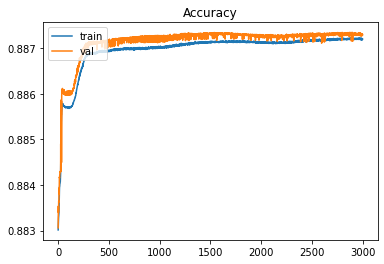

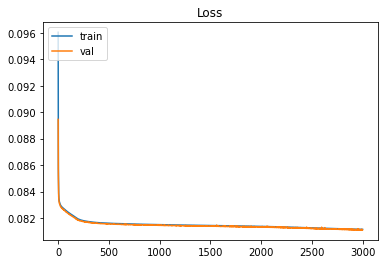

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [40]:
#모델 평가
model = load_model('model_mlp_100.h5')
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(Y_test, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(Y_test, y_pred, target_names=target_names))

#위의 코드의 옛날버전
model_predictions = model.predict_classes(X_test, batch_size=200, verbose=0)
print(confusion_matrix(Y_test, model_predictions))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(Y_test,model_predictions, target_names=target_names))
del model

[[4616804 1394482]
 [ 245035  686667]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.77      0.85   6011286
      class1       0.33      0.74      0.46    931702

    accuracy                           0.76   6942988
   macro avg       0.64      0.75      0.65   6942988
weighted avg       0.87      0.76      0.80   6942988

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[4616804 1394482]
 [ 245035  686667]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.77      0.85   6011286
      class1       0.33      0.74      0.46    931702

    accuracy                           0.76   6942988